In [1]:
! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab

--2019-12-13 13:44:01--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1991 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.94K  --.-KB/s    in 0s      

2019-12-13 13:44:06 (37.3 MB/s) - ‘setup_google_colab.py’ saved [1991/1991]



### ***Predict Tags on stackoverflow with Linear model:***

In [0]:
setup_google_colab.setup_week1() 

In [3]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

In [0]:
from grader import Grader
grader = Grader()

In [5]:
#text preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [0]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [0]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [9]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [0]:
#initialize X_train, X_val, X_test, y_train, y_val.
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [0]:
import re

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    # lowercase text
    text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    # delete stopwords from text
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    return text

In [0]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [14]:
print(test_text_prepare())

Basic tests are passed.


In [15]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


In [0]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [17]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

In [0]:
#Word tags count
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}
from collections import Counter
tags_counts = Counter([tag for taglist in y_train for tag in taglist])
words_counts = Counter([word for question in X_train for word in question.split(' ')])

In [19]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

grader.submit_tag('WordsTagsCount', '%s\n%s' % (','.join(tag for tag, _ in most_common_tags), 
                                                ','.join(word for word, _ in most_common_words)))

Current answer for task WordsTagsCount is:
 javascript,c#,java
using,php,java...


In [0]:
#transforming text to vector

# Bag of words implementation
DICT_SIZE = 5000
WORDS_TO_INDEX = {word[0]:int_idx for int_idx, word in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])}
INDEX_TO_WORDS = dict(zip(WORDS_TO_INDEX.values(),WORDS_TO_INDEX.keys()))
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    text_tokenized = text.split(' ')
    for token in text_tokenized:
        if token in words_to_index:
            result_vector[words_to_index[token]] += 1
    return result_vector

In [0]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [22]:
print(test_my_bag_of_words())

Basic tests are passed.


In [0]:
from scipy import sparse as sp_sparse

In [24]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [25]:
row = X_train_mybag[10].toarray()[0]

non_zero_elements_count = (row != 0).sum()

grader.submit_tag('BagOfWords', str(non_zero_elements_count))

Current answer for task BagOfWords is:
 7...


In [0]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result

    tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern = '(\S+)', min_df = 5, max_df = 0.9, ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

In [0]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [28]:
all([tag in tfidf_vocab for tag in ['c++','c#']])

True

In [29]:
all([tag in tfidf_vocab for tag in ['c++','c#']])

True

In [0]:
#MULTILABEL CLASSIFIER
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [0]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    

    clf = OneVsRestClassifier(LogisticRegression())
    clf.fit(X_train,y_train)
    
    return clf

In [33]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [35]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




In [0]:
# EVALUVATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [0]:
def print_evaluation_scores(y_val, predicted):
    
    # Accuracy
    print('Acuracy score: {:.2f}'.format(accuracy_score(y_val, predicted)))
    # F1-Score
    print('F1-Score macro-average: {:.2f}'.format(f1_score(y_val,predicted,average='macro')))
    print('F1-Score micro-average: {:.2f}'.format(f1_score(y_val,predicted,average='micro')))
    print('F1-Score weighted-average: {:.2f}'.format(f1_score(y_val,predicted,average='weighted')))
    # Precision
    print('Precision macro-average: {:.2f}'.format(average_precision_score(y_val,predicted,average='macro')))
    print('Precision micro-average: {:.2f}'.format(average_precision_score(y_val,predicted,average='micro')))
    print('Precision weighted-average: {:.2f}'.format(average_precision_score(y_val,predicted,average='weighted')))

In [38]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Acuracy score: 0.36
F1-Score macro-average: 0.50
F1-Score micro-average: 0.67
F1-Score weighted-average: 0.65
Precision macro-average: 0.34
Precision micro-average: 0.48
Precision weighted-average: 0.51
Tfidf
Acuracy score: 0.33
F1-Score macro-average: 0.45
F1-Score micro-average: 0.64
F1-Score weighted-average: 0.61
Precision macro-average: 0.30
Precision micro-average: 0.46
Precision weighted-average: 0.49


In [0]:
from metrics import roc_auc
%matplotlib inline

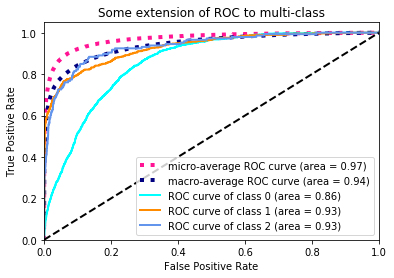

In [40]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

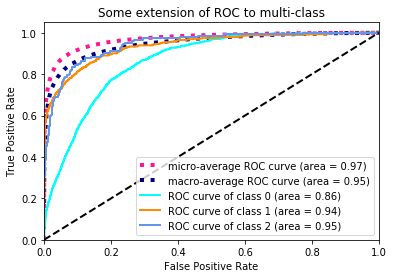

In [41]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

In [42]:
def grid_search(c,penalty,X_train_mybag,X_train_tfidf,X_val_mybag,X_val_tfidf,y_train,y_val):
    
    # Define model
    clf = OneVsRestClassifier(LogisticRegression(C = c, penalty = penalty))
    
    # Fit and predict mybag
    clf_mybag = clf.fit(X_train_mybag,y_train)
    y_val_predicted_labels_mybag = clf_mybag.predict(X_val_mybag)
 
    # Fit and predict tfidf
    clf_tfidf = clf.fit(X_train_tfidf,y_train)
    y_val_predicted_labels_tfidf = clf_tfidf.predict(X_val_tfidf)
    
    # Evaluate
    print("For parameters C={}, penalty={}".format(c,penalty))
    print("mybag: F1-score = {:.2f}".format(f1_score(y_val, y_val_predicted_labels_mybag, average = 'weighted'
)))
    print("tfidf: F1-score = {:.2f}".format(f1_score(y_val, y_val_predicted_labels_tfidf, average = 'weighted'
)))


    
from itertools import product
C = [0.1,1,10,100]
regularization = ['l1','l2']
grid = list(product(C,regularization))

for c,reg in grid:
    grid_search(c,reg,X_train_mybag,X_train_tfidf,X_val_mybag,X_val_tfidf,y_train,y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=0.1, penalty=l1
mybag: F1-score = 0.61


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


tfidf: F1-score = 0.57


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=0.1, penalty=l2


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


mybag: F1-score = 0.59
tfidf: F1-score = 0.39


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=1, penalty=l1
mybag: F1-score = 0.66
tfidf: F1-score = 0.65


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=1, penalty=l2
mybag: F1-score = 0.65
tfidf: F1-score = 0.61


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=10, penalty=l1
mybag: F1-score = 0.65
tfidf: F1-score = 0.65


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=10, penalty=l2
mybag: F1-score = 0.65
tfidf: F1-score = 0.65


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=100, penalty=l1
mybag: F1-score = 0.62
tfidf: F1-score = 0.59


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For parameters C=100, penalty=l2
mybag: F1-score = 0.63
tfidf: F1-score = 0.63


In [43]:
clf = OneVsRestClassifier(LogisticRegression(C = 1, penalty = 'l1'))
clf_mybag = clf.fit(X_train_mybag,y_train)
test_predictions = clf_mybag.predict(X_test_mybag)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


In [44]:
clf = OneVsRestClassifier(LogisticRegression(C = 1, penalty = 'l1'))
clf_mybag = clf.fit(X_train_mybag,y_train)
test_predictions = clf_mybag.predict(X_test_mybag)
test_pred_inversed = mlb.inverse_transform(test_predictions)

test_predictions_for_submission = '\n'.join('%i\t%s' % (i, ','.join(row)) for i, row in enumerate(test_pred_inversed))
grader.submit_tag('MultilabelClassification', test_predictions_for_submission)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Current answer for task MultilabelClassification is:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


In [0]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))

    coef = classifier.coef_[tags_classes.index(tag)]
    coef_dict = {idx:c for idx,c in enumerate(coef.tolist())}
    sorted_coefs = sorted(coef_dict.items(), key=lambda x: x[1], reverse=True)
    
    # top-5 words sorted by the coefficiens.
    top_positive_words = [index_to_words[i[0]] for i in sorted_coefs[:5]]
    # bottom-5 words  sorted by the coefficients.
    top_negative_words = [index_to_words[i[0]] for i in sorted_coefs[-5:]]
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [46]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, malloc, scanf, printf, gcc
Top negative words:	c#, javascript, python, php, java

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	c#, javascript, python, php, java

Tag:	linux
Top positive words:	linux, ubuntu, c, address, signal
Top negative words:	method, array, jquery, c#, javascript



In [47]:
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


In [48]:
STUDENT_EMAIL = 'rthirumurugan2000@gmail.com' # EMAIL 
STUDENT_TOKEN = 'WEqZBhwBdsk4A20e' # TOKEN 
grader.status()

You want to submit these parts:
Task TextPrepare:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...
Task WordsTagsCount:
 javascript,c#,java
using,php,java...
Task BagOfWords:
 7...
Task MultilabelClassification:
 0	mysql,php
1	javascript
2	
3	javascript,jquery
4	android,java
5	php,xml
6	json,web-services
7	java,...


In [49]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
